In [ ]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import numpy as np
from scipy.stats import median_abs_deviation

from testing import adata

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [ ]:
os.getcwd()

'C:\\Users\\HP\\PycharmProjects\\pythonProject'

Pre-processing

In [ ]:
#some pre-requisite function to be used during pre-processing
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


In [ ]:
# This code processes gene expression data for different cell lines isolated from the bone marrow niches
# filters out low-quality cells and genes, and calculates metrics
# for mitochondrial and ribosomal gene expression before saving as a H5AD file.
#the mitchondrial and ribosomal count will be used to filter out low quality cells later on

files = os.listdir('./Lung Atlas') #directory that contains count matrices

def pre_processing(files):

    for file in files:
        cell_type = file.split('-')[1]
        cell_type = cell_type.split('.')[0]
        path = f'./Lung Atlas/{file}'

        adata = sc.read_text(path).T
        adata.X = csr_matrix(adata.X) #convert the count matrix to a sparse matrix

        sc.pp.filter_cells(adata, min_genes= 200)
        sc.pp.filter_genes(adata, min_cells=3)
        adata.var['mt'] = adata.var_names.str.startswith('Mt')
        adata.var['ribo'] = adata.var_names.str.startswith(('Rpl', 'Rps'))
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], inplace=True,
                                   percent_top = None, log1p = False)

        adata.write_h5ad(f'./data_h5ad/{cell_type}.h5ad')


In [ ]:
pre_processing(files)

NameError: name 'adata' is not defined

In [ ]:
files = os.listdir('./data_h5ad')
def plot_metric(files):
    plot_list = []
    for file in files:
        cell_type = file.split('.')[0]
        fig, ax = plt.subplots()
        adata = sc.read_h5ad( f'./data_h5ad/{file}')
        sc.pl.violin(adata, ['pct_counts_mt'], ax=ax, show=False)
        ax.set_title(f'Mitochondrial Percentage - {cell_type}')
        plot_list.append(fig)


Analyzing the mitochondrial percentage across these cell populations reveals that all lines remain below 5%, with the majority of cells clustering tightly between 0% and 1%. thus, our cells are of good quality.

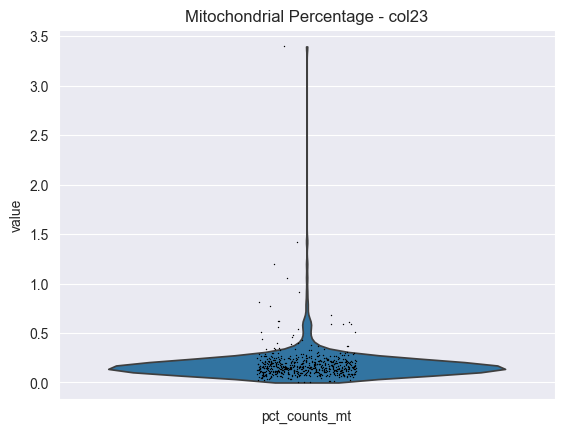

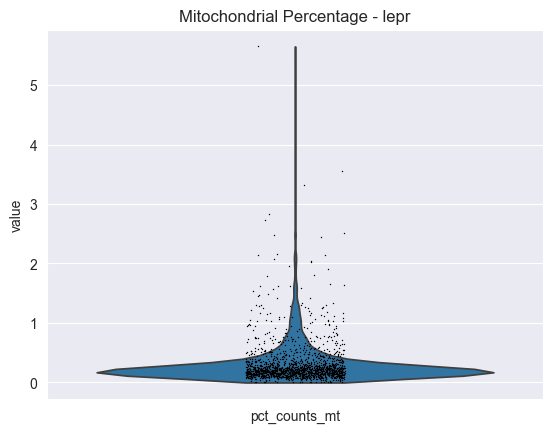

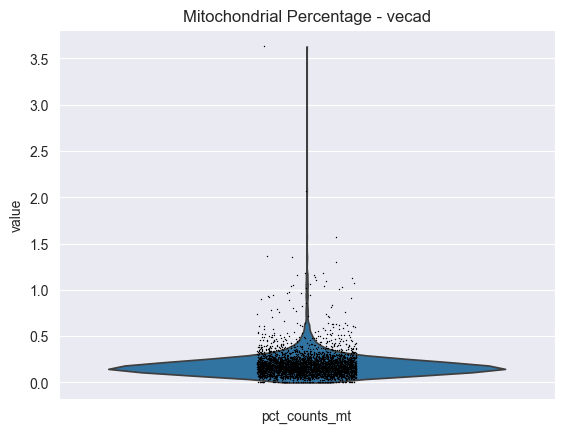

In [ ]:
plot_metric(files)

Ambient RNA correction

In [3]:
import scanpy as sc
import scvi
import os

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [7]:
def remove_doublet(files):
    for file in files:
      cell_type = file.split('.')[0]
      adata = sc.read_h5ad(f'./sample_data/{file}')
      scvi.model.SCVI.setup_anndata(adata)
      vae = scvi.model.SCVI(adata)
      vae.train()
      solo = scvi.external.SOLO.from_scvi_model(vae)
      solo.train()

      df = solo.predict()
      df['prediction'] = solo.predict(soft = False)
      df['dif'] = df.doublet - df.singlet
      doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]

      adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
      adata = adata[~adata.obs.doublet]

      adata.write_h5ad(f'./data_h5ad/{cell_type}.db.h5ad')


Quality Control